# Simple skill assessment for HydroTas 2020-2021 workplan:
- rainfall, surface temp and surface wind over Australia region and Tasmania region
- Assess skill as function of start month and ensemble size

In [1]:
import sys
sys.path.insert(0, '/OSM/CBR/OA_DCFP/work/squ027/software/xskillscore')

import cmocean
import matplotlib
import numpy as np
import xarray as xr
import myfuncs as my
import xskillscore as xs
from matplotlib import cm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Parameters

In [139]:
CLIM_PERIOD = slice('1990-01-01', '2019-12-31') # For defining climatological probabilities
TEST_PERIOD = slice('1990-01-01', '2019-12-31')
ROLLING_LEAD_AVERAGES = [3, 6, 12, 24, 36, 60]
REGIONS = ['AUS', 'MEL', 'TAS']
CMAP = matplotlib.colors.ListedColormap(
    cm.get_cmap(cmocean.cm.curl_r)(np.linspace(0, 1, 21)))

PARAMS = {'precip': 
             {'obsv_file': 'data/awap_precip_{region}.zarr',
              'fcst_file': 'data/f6_precip_{region}.zarr'},
          't_ref':
             {'obsv_file': 'data/jra55_t_ref_{region}.zarr',
              'fcst_file': 'data/f6_t_ref_{region}.zarr'},
          'V_ref':
             {'obsv_file': 'data/jra55_V_ref_{region}.zarr',
              'fcst_file': 'data/f6_V_ref_{region}.zarr'}}

# Perform skill assessment using MSSS and CRPSS

In [140]:
def get_climatological_probabilities(obsv, period):
    def _init_date_to_ensemble(ds):
        """ Collapse all available init_dates at a given lead into a new ensemble dimension"""
        ds_drop = ds.copy().dropna('init_date', how='all')
        ds_drop = ds_drop.rename({'init_date': 'ensemble'})
        return ds_drop.assign_coords({'ensemble': range(len(ds_drop['ensemble']))})
    obsv_period = my.mask_time_period(obsv, period=period)
    obsv_ensemble = obsv_period.groupby('lead_time').map(_init_date_to_ensemble)
    clim_prob = obsv_ensemble.broadcast_like(obsv)
    return clim_prob.assign_coords({'time': obsv['time']})

In [141]:
def get_rolling_leadtime_averages(ds, list_of_months_to_average):
    """ Return rolling averages along lead time stacked along new dimension"""
    def _rolling_leadtime_average(ds, n_points, lead_time_name='lead_time'):
        return ds.rolling({lead_time_name: n_points}, center=True).mean()
    dst_dict = {'1 month': ds}
    for avg in list_of_months_to_average:
        dst_dict[str(avg)+' months'] = _rolling_leadtime_average(dst_dict['1 month'], 
                                                                 n_points=avg)
    dst = xr.concat(dst_dict.values(), dim='time_scale')
    dst = dst.assign_coords(time_scale=[int(time_scale.split(' ')[0]) 
                                        for time_scale in dst_dict.keys()])
    dst = dst.assign_coords(time_scale_name=('time_scale', list(dst_dict.keys())))
    return dst

In [196]:
fcst = my.open_zarr('data/f5_precip_TAS_anom.zarr').compute()
obsv = my.open_zarr('data/awap_precip_TAS_anom.zarr').compute()

In [200]:
start_months = np.unique(fcst.init_date.dt.month)
start_month = start_months[0]

In [201]:
keep_mon = obsv.init_date.dt.month == start_month
fcst_mon = get_rolling_leadtime_averages(
    fcst.where(keep_mon, drop=True), 
    ROLLING_LEAD_AVERAGES)
obsv_mon = get_rolling_leadtime_averages(
    obsv.where(keep_mon, drop=True), 
    ROLLING_LEAD_AVERAGES)
fcst_mon, obsv_mon = xr.align(fcst_mon, obsv_mon)

In [202]:
clim_probs_mon = get_climatological_probabilities(obsv_mon, CLIM_PERIOD)
clim_mean_mon = 0 * clim_probs_mon.mean('ensemble')

In [203]:
acc = my.get_metric(
    obsv_mon, fcst_mon.mean('ensemble'),
    metric='pearson_r', 
    metric_kwargs={'dim': 'init_date',
                   'skipna': True},
    period=TEST_PERIOD)

In [204]:
msss = my.get_skill_score(
    obsv_mon, fcst_mon.mean('ensemble'), clim_mean_mon,
    metric='mse', 
    metric_kwargs={'dim': 'init_date',
                   'skipna': True},
    period=TEST_PERIOD)

In [205]:
crpss = my.get_skill_score(
    obsv_mon, fcst_mon, clim_probs_mon,
    metric='crps_ensemble', 
    metric_kwargs={'member_dim': 'ensemble',
                   'dim': 'init_date'},
    period=TEST_PERIOD)

In [206]:
def jelly_plot(skill, stipple=None, stipple_type='//',
               title=None, cmap=None, vlims=None, figsize=None):
    
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.patches as mpatches
    
    def _stipple(stipple, stipple_type):
        if '/' in stipple_type:
            for j, i in np.column_stack(
                np.where(stipple)):
                ax.add_patch(
                    mpatches.Rectangle((i, j-0.5), 1, 1,    
                                       fill=False, linewidth=0,
                                       snap=False, hatch=stipple_type))
        else:
            xOrg = range(len(stipple[stipple.dims[1]]))
            yOrg = range(len(stipple[stipple.dims[0]]))
            nx = len(xOrg)
            ny = len(yOrg)
            xData = np.reshape( np.tile(xOrg, ny), stipple.shape )
            yData = np.reshape( np.repeat(yOrg, nx), stipple.shape )
            sigPoints = stipple > 0
            xPoints = xData[sigPoints.values]
            yPoints = yData[sigPoints.values]
            ax.scatter(xPoints+0.5, yPoints, s=5, c='k', marker=stipple_type, alpha=1)
        
    fig, ax = plt.subplots(figsize=figsize)
    
    if vlims is None:
        vlims = [None, None]
               
    x = np.arange(len(skill.lead_time)+1)
    y = np.arange(len(skill.time_scale)+1)-0.5
    c = skill.transpose('time_scale','lead_time')
    im = ax.pcolor(x, y, c,
                    vmin=vlims[0],
                    vmax=vlims[1],
                    cmap=cmap)
    
    if stipple is not None:
        _stipple(stipple.transpose('time_scale','lead_time'), stipple_type)
    
    # Plot annotations
    for y, ts in enumerate(skill.time_scale.values):
        if y != 0:
            ends = 0.15
            line_color = 'grey'
            ax.plot([0.5, ts-0.5], [y, y], 
                    color=line_color, linewidth=1)
            ax.plot([0.5, 0.5], [y-ends, y+ends], 
                    color=line_color, linewidth=1)
            ax.plot([ts-0.5, ts-0.5], [y-ends, y+ends], 
                    color=line_color, linewidth=1)
            ax.plot([int(ts/2)+0.5], y,
                    marker='x', color=line_color, markersize=4, linewidth=1)
    
    # Add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='8%', pad=0.55)
    fig.colorbar(im, cax=cax, orientation='horizontal')
    
    ax.set_yticks(range(len(skill.time_scale)))
    ax.set_yticklabels(skill.time_scale_name.values)
    ax.set_xlabel('Lead month')
    ax.set_ylabel('Averaging period')
    
    if title:
        ax.set_title(title)

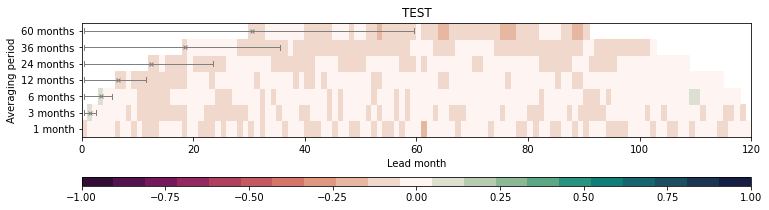

In [195]:
jelly_plot(crpss['precip'], None, stipple_type='//',
           title='TEST',
           cmap=CMAP, vlims=(-1,1), figsize=(12,3))

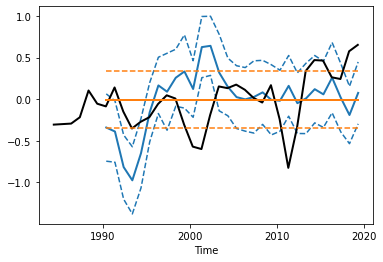

In [170]:
import matplotlib.pyplot as plt

lead = 30
time_scale = 24 # month
variable = 't_ref'

std = my.mask_time_period(
    fcst_mon.sel(time_scale=time_scale).std('ensemble')[variable].isel(lead_time=lead),
    TEST_PERIOD)
mean = my.mask_time_period(
    fcst_mon.sel(time_scale=time_scale).mean('ensemble')[variable].isel(lead_time=lead),
    TEST_PERIOD)
plt.plot(mean.time, (mean - std), color='C0', linestyle='--')
plt.plot(mean.time, (mean + std), color='C0', linestyle='--')
plt.plot(mean.time, mean, color='C0', linewidth=2)

ref = obsv_mon.sel(time_scale=time_scale)[variable].isel(lead_time=lead)
plt.plot(ref.time, ref, color='k', linewidth=2)

std = my.mask_time_period(
    clim_probs_mon.sel(time_scale=time_scale).std('ensemble')[variable].isel(lead_time=lead),
    TEST_PERIOD)
mean = my.mask_time_period(
    clim_probs_mon.sel(time_scale=time_scale).mean('ensemble')[variable].isel(lead_time=lead),
    TEST_PERIOD)
plt.plot(mean.time, (mean - std).where(ref.notnull()), color='C1', linestyle='--')
plt.plot(mean.time, (mean + std).where(ref.notnull()), color='C1', linestyle='--')
plt.plot(mean.time, mean.where(ref.notnull()), color='C1', linewidth=2)

plt.xlabel('Time');